In [4]:
import pandas as pd
import numpy as np

PATH = "../data/processed/merged.csv"
df = pd.read_csv(PATH)

print("Rows:", len(df))
df.head(2)


Rows: 9183


,id,latitude,longitude,neighbourhood_cleansed,room_type,property_type,accommodates,bedrooms,bathrooms_num,minimum_nights,price_eur,review_scores_rating,number_of_reviews,unavailable_rate_90d
0,3176,52.53471,13.41810,Prenzlauer Berg Südwest,Entire home/apt,Entire rental unit,2,1.0,1.0,63,105.0,4.63,149,0.0
1,9991,52.53269,13.41805,Prenzlauer Berg Südwest,Entire home/apt,Entire rental unit,7,4.0,2.5,6,135.0,5.00,7,0.0


In [5]:
# Zielvariable
y = df["price_eur"]

# Kandidaten-Features (werden gefiltert, falls Spalten fehlen)
feat_candidates = [
    "accommodates","bedrooms","bathrooms_num","minimum_nights",
    "review_scores_rating","number_of_reviews",
    "room_type","property_type","neighbourhood_cleansed",
    "latitude","longitude","unavailable_rate_90d"
]
feats = [c for c in feat_candidates if c in df.columns]
X = df[feats].copy()

X.dtypes, len(feats)


(accommodates                int64
 bedrooms                  float64
 bathrooms_num             float64
 minimum_nights              int64
 review_scores_rating      float64
 number_of_reviews           int64
 room_type                  object
 property_type              object
 neighbourhood_cleansed     object
 latitude                  float64
 longitude                 float64
 unavailable_rate_90d      float64
 dtype: object,
 12)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape


((7346, 12), (1837, 12))

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X.select_dtypes(include="object").columns.tolist()

pre = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)


In [8]:
from sklearn.ensemble import RandomForestRegressor

Xtr = pre.fit_transform(X_train)
Xte = pre.transform(X_test)

model = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
model.fit(Xtr, y_train)


,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
from sklearn.metrics import mean_absolute_error, r2_score

pred = model.predict(Xte)
mae = mean_absolute_error(y_test, pred)
r2  = r2_score(y_test, pred)
print(f"MAE: €{mae:,.2f}")
print(f"R² : {r2:.3f}")


MAE: €36.90
R² : 0.635


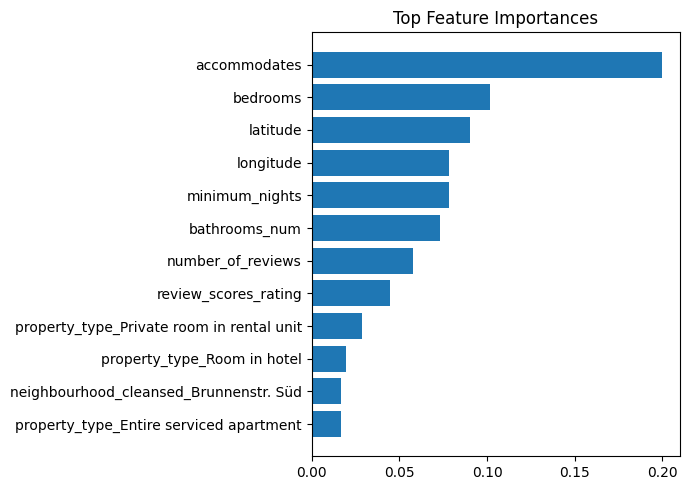

,feature,importance
201,accommodates,0.200080
202,bedrooms,0.101686
207,latitude,0.090223
208,longitude,0.078140
204,minimum_nights,0.078042
203,bathrooms_num,0.073019
206,number_of_reviews,0.057652
205,review_scores_rating,0.044890
42,property_type_Private room in rental unit,0.028858
52,property_type_Room in hotel,0.019346


In [10]:
import pandas as pd, matplotlib.pyplot as plt
import numpy as np

# Namen der transformierten Merkmale rekonstruieren
ohe = pre.named_transformers_.get("cat")
cat_names = ohe.get_feature_names_out(cat_cols).tolist() if cat_cols else []
num_cols = [c for c in feats if c not in cat_cols]
feat_names = cat_names + num_cols

imp = pd.DataFrame({"feature": feat_names, "importance": model.feature_importances_})
imp = imp.sort_values("importance", ascending=False).head(12)

plt.figure(figsize=(7,5))
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title("Top Feature Importances")
plt.tight_layout()
plt.savefig("../reports/figures/feature_importance.png", dpi=160)
plt.show()

imp


In [16]:
import os, joblib
os.makedirs("../src", exist_ok=True)  # create if missing
joblib.dump({"pre": pre, "model": model, "features": feats}, "../src/price_model.joblib")
"../src/price_model.joblib"



'../src/price_model.joblib'